✅ Features Extracted
Total Samples: 3807
Fitting 3 folds for each of 108 candidates, totalling 324 fits

🏆 Best RF Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

🎯 Accuracy: 68.77%

🔥 Confusion Matrix:
[[411 165]
 [192 375]]

🔥 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.71      0.70       576
           1       0.69      0.66      0.68       567

    accuracy                           0.69      1143
   macro avg       0.69      0.69      0.69      1143
weighted avg       0.69      0.69      0.69      1143



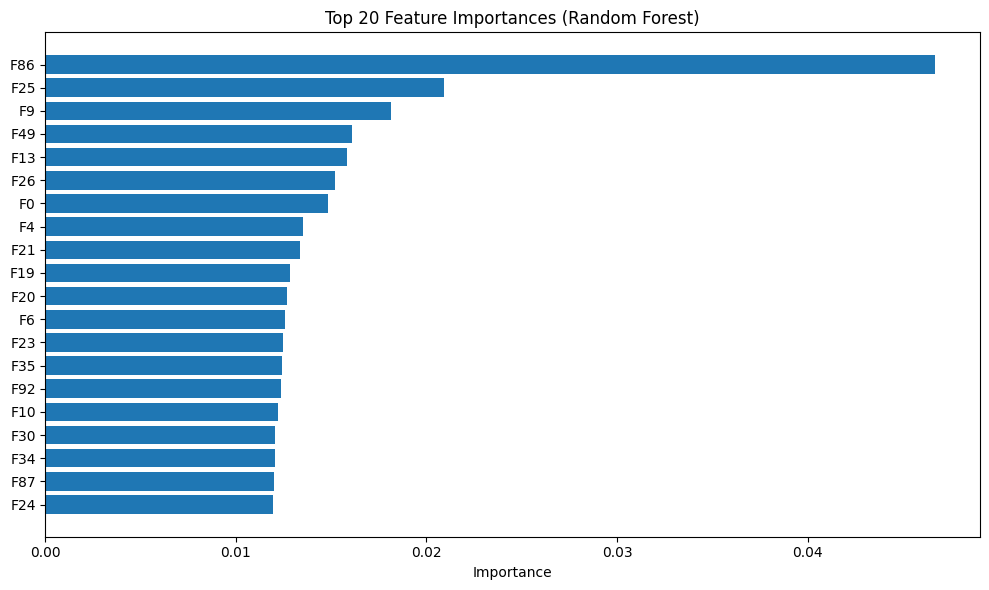

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight

# ===============================
# Step 1: Setup
# ===============================
DATASET_PATH = r"D:\\"  # Change this if needed
MACHINE_TYPES = ["fan", "pump", "gearbox"]
X_all = []
y_all = []

# ===============================
# Step 2: Advanced Feature Extraction
# ===============================
def extract_features(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        features = np.hstack([
            np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(zcr), np.std(zcr),
            np.mean(rms), np.std(rms),
            np.mean(chroma_stft), np.std(chroma_stft),
            np.mean(rolloff), np.std(rolloff),
            np.mean(tonnetz), np.std(tonnetz)
        ])

        return features
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None

# ===============================
# Step 3: Load and Label Data
# ===============================
for machine in MACHINE_TYPES:
    for test_type in ["source_test", "target_test"]:
        folder = os.path.join(DATASET_PATH, machine, test_type)
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".wav"):
                    path = os.path.join(root, file)
                    label = 1 if "anomaly" in file else 0
                    features = extract_features(path)
                    if features is not None:
                        X_all.append(features)
                        y_all.append(label)

print("✅ Features Extracted")
print("Total Samples:", len(X_all))

# ===============================
# Step 4: Prepare Dataset
# ===============================
X = np.array(X_all)
y = np.array(y_all)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# ===============================
# Step 5: Class Weights
# ===============================
weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

# ===============================
# Step 6: Grid Search for Random Forest
# ===============================
params = {
    'n_estimators': [300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, class_weight='balanced')

grid = GridSearchCV(estimator=rf, param_grid=params, cv=3, scoring='accuracy',
                    verbose=1, n_jobs=-1)
grid.fit(X_train, y_train, sample_weight=weights)

best_rf = grid.best_estimator_
print("\n🏆 Best RF Parameters:", grid.best_params_)

# ===============================
# Step 7: Evaluate
# ===============================
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy: {acc*100:.2f}%")
print("\n🔥 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n🔥 Classification Report:")
print(classification_report(y_test, y_pred))

# ===============================
# Step 8: Plot Feature Importances
# ===============================
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances (Random Forest)")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [f"F{i}" for i in indices])
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [2]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ================================
# Step 1: Setup
# ================================
DATASET_PATH = r"D:\\"  # change if needed
MACHINE_TYPES = ["fan", "pump", "gearbox"]
X_all = []
y_all = []

# ================================
# Step 2: Advanced Feature Extraction (mean + std)
# ================================
def extract_features(file_path, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=None)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rms = librosa.feature.rms(y=y)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        features = np.hstack([
            np.mean(mfcc, axis=1), np.std(mfcc, axis=1),
            np.mean(spectral_centroid), np.std(spectral_centroid),
            np.mean(spectral_bandwidth), np.std(spectral_bandwidth),
            np.mean(zcr), np.std(zcr),
            np.mean(rms), np.std(rms),
            np.mean(chroma_stft), np.std(chroma_stft),
            np.mean(rolloff), np.std(rolloff),
            np.mean(tonnetz), np.std(tonnetz)
        ])

        return features
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None

# ================================
# Step 3: Load Data
# ================================
for machine in MACHINE_TYPES:
    for test_type in ["source_test", "target_test"]:
        folder = os.path.join(DATASET_PATH, machine, test_type)
        for root, _, files in os.walk(folder):
            for file in files:
                if file.endswith(".wav"):
                    path = os.path.join(root, file)
                    label = 1 if "anomaly" in file else 0
                    features = extract_features(path)
                    if features is not None:
                        X_all.append(features)
                        y_all.append(label)

print("✅ All Features Extracted")
print("Total Samples:", len(X_all))

# ================================
# Step 4: Preprocess
# ================================
X = np.array(X_all)
y = np.array(y_all)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# ================================
# Step 5: Define Base Models
# ================================
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True
)

# ================================
# Step 6: Build Ensemble
# ================================
ensemble = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('svm', svm_model)
    ],
    voting='soft',  # soft = uses predicted probabilities
    n_jobs=-1
)

print("🚀 Training Ensemble...")
ensemble.fit(X_train, y_train)

# ================================
# Step 7: Evaluate
# ================================
y_pred = ensemble.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\n🎯 Ensemble Accuracy: {:.2f}%".format(acc * 100))
print("\n🔥 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n🔥 Classification Report:")
print(classification_report(y_test, y_pred))


✅ All Features Extracted
Total Samples: 3807
🚀 Training Ensemble...

🎯 Ensemble Accuracy: 72.18%

🔥 Confusion Matrix:
[[425 151]
 [167 400]]

🔥 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       576
           1       0.73      0.71      0.72       567

    accuracy                           0.72      1143
   macro avg       0.72      0.72      0.72      1143
weighted avg       0.72      0.72      0.72      1143

